## Watson Text to Speech Analysis


### What you'll learn in this notebook
Watson Text to Speech offers so-called parameters for various Speech To text recoganization This Notebook Shows :

## Table of Contents


1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Text To Speech Recognition](#STT)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [1]:
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import pandas as pd
%matplotlib inline
import soundfile as sf

<a id="loadData"></a>
## 2. Data Loading (Text Data)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Topic modeling on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet"><strong>Step 2.1</strong> We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This data set contains 999285 consumer complaints with the date received,product,sub-product, submitted via and company information.</span>

In [2]:
def print_plot_play(fileName, text=''):
    x, Fs = librosa.load(fileName, sr=None)
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(10, 5))
    plt.plot(x, color='blue')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

<a id="STT"></a>
## 3. Text To Speech Recognition

<span style="color:blueviolet"> <strong>Step 3.1 <strong>Using Kuberneets Watson Text to speech Service</span>

In [92]:
import requests
# Setting up the headers for post request to service 
headers = {"Content-Type": "application/json","Accept":"audio/wav"}
#Setting up params
params ={'output':'output_text.wav'}

In [93]:
#speech url , here port defines on basis of kubernetes port forword 
text_to_speech_url ='http://localhost:1080/text-to-speech/api/v1/synthesize'

In [94]:
data ='{"text":"Text to Speech service provides APIs that use IBM\'s speech-synthesis capabilities to synthesize text into natural-sounding speech in a variety of languages, dialects, and voices"}'

In [95]:
# method to get the values from the speech service 
def getSpeechFromText(headers,params,data,file_name):
    request =requests.post(text_to_speech_url,headers=headers,params =params,data=data)
    print(request.status_code)
    with open(file_name, mode='bx') as f:
        f.write(request.content)
    

In [97]:
file_name = 'text_to_speech_sample1.wav'

In [98]:
result = getSpeechFromText(headers,params,data,file_name)

200


 Fs = 22050, x.shape = (247280,), x.dtype = float32


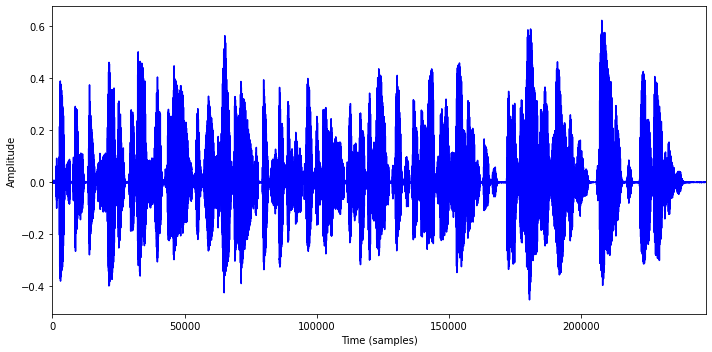

In [99]:
print_plot_play(file_name)

### Modifying speech synthesis characteristics : 
Text to Speech service includes query parameters that you can use to globally modify the characteristics of speech synthesis for an entire request: 
1. rate_percentage
1. pitch_percentage
1. spell_out_mode. 

In [104]:
params ={'voice':'en-US_AllisonV3Voice','rate_percentage':-5}
file_name ="text_to_speeh_rate.wav"

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


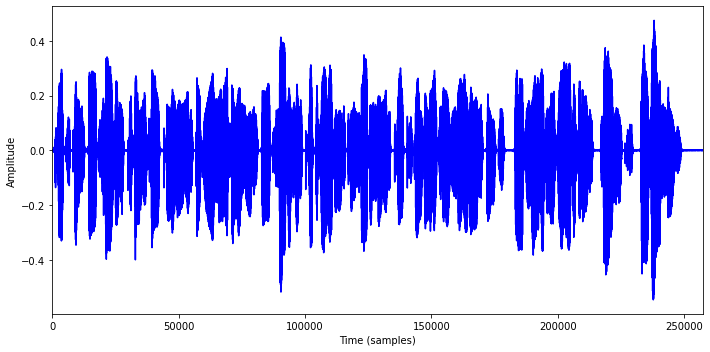

In [105]:
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


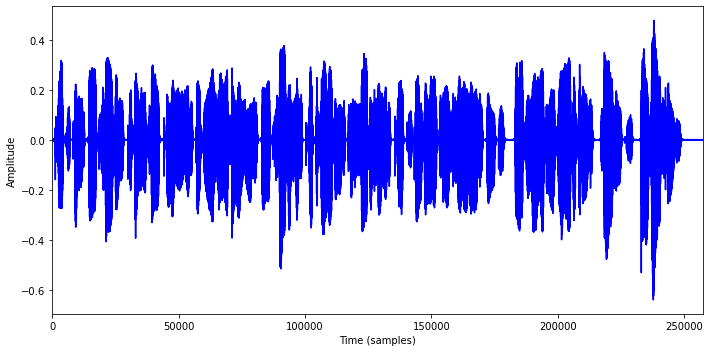

In [106]:
params ={'voice':'en-US_AllisonV3Voice','rate_percentage':40}
file_name ="text_to_speeh_rate4.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


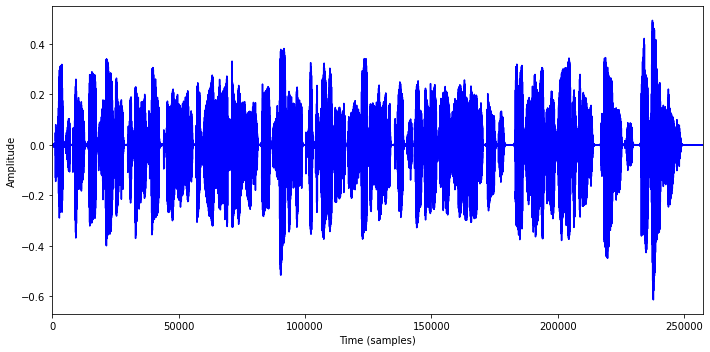

In [107]:
params ={'voice':'en-US_AllisonV3Voice','pitch_percentage':-10}
file_name ="text_to_speeh_pitch.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


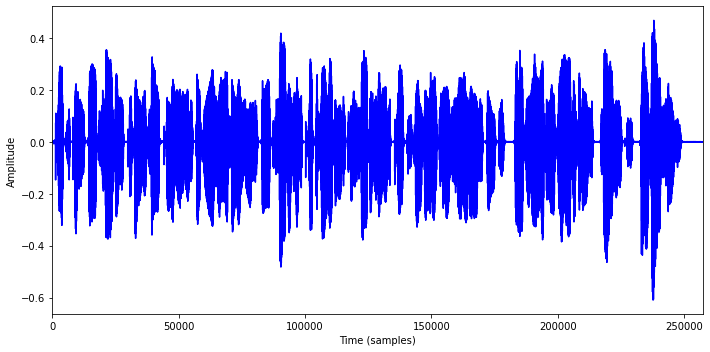

In [108]:
params ={'voice':'en-US_AllisonV3Voice','pitch_percentage':20}
file_name ="text_to_speeh_pitch1.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

<a id="summary"></a>
## 4. Summary

<span style="color:blue">This notebook shows you how to use the Watson Text to speech library:</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 